# Lecture X: GPU-Accelerated Python with CuPy and Numba

*LSST DSFP Session 21*

*Instructor: Lehman Garrison (https://github.com/lgarrison)*

**Goals**

In this lecture, we'll:
- introduce GPU computing
- compare with CPU computing
- use CuPy to interact with the GPU at a high level
- learn about the CUDA programming model
- use Numba to program the GPU at a low level

**Credit**

Parts of this lecture were adapted from Jacob Tomlinson's excellent [GPU Python Tutorial](https://github.com/jacobtomlinson/gpu-python-tutorial/). There's more material there than we'll have time to cover today, so check it out if you want to learn more!

## Introduction to GPUs

CPUs are the most common type of processor. By default, programs on your laptop or a cluster run on the CPU. When you run:

```console
$ python
>>> import numpy as np
>>> np.arange(100)
```

you're starting a Python process on the CPU and allocating a NumPy array in CPU memory (aka RAM).

A graphics processing unit, or GPU, is a co-processor that specializes in highly parallel calculations. "Co-processor" means that it's like a mini-computer with its own cores and own memory that runs alongside the CPU. Computations can be "offloaded" from the CPU to the GPU, but this requires some effort on the part of the programmer.

### A bit of history...
GPUs started out as specialized devices for accelerating graphics rendering, mostly for video games! Processing millions of pixels in parallel turned out to be analogous to many problems in scientific computing, like matrix multiplication, so clever programmers found ways to pose numerical algorithms as graphics computations. Eventually, the potential of GPUs for general-purpose computing was recognized, so today we use dedicated GPU programming languages rather than graphics libraries.

But it was really with the advent of machine learning and its commercial applications that GPU computing became the behemoth it is today. Scientific computing often rides the coattails of business and industry—we need to be adaptable and use technologies as they become available to us!

### GPUs vs CPUs

We said that GPUs are highly parallel processors; let's break that down a bit. Here's a architectural schematic of a CPU on the left and a GPU on the right:

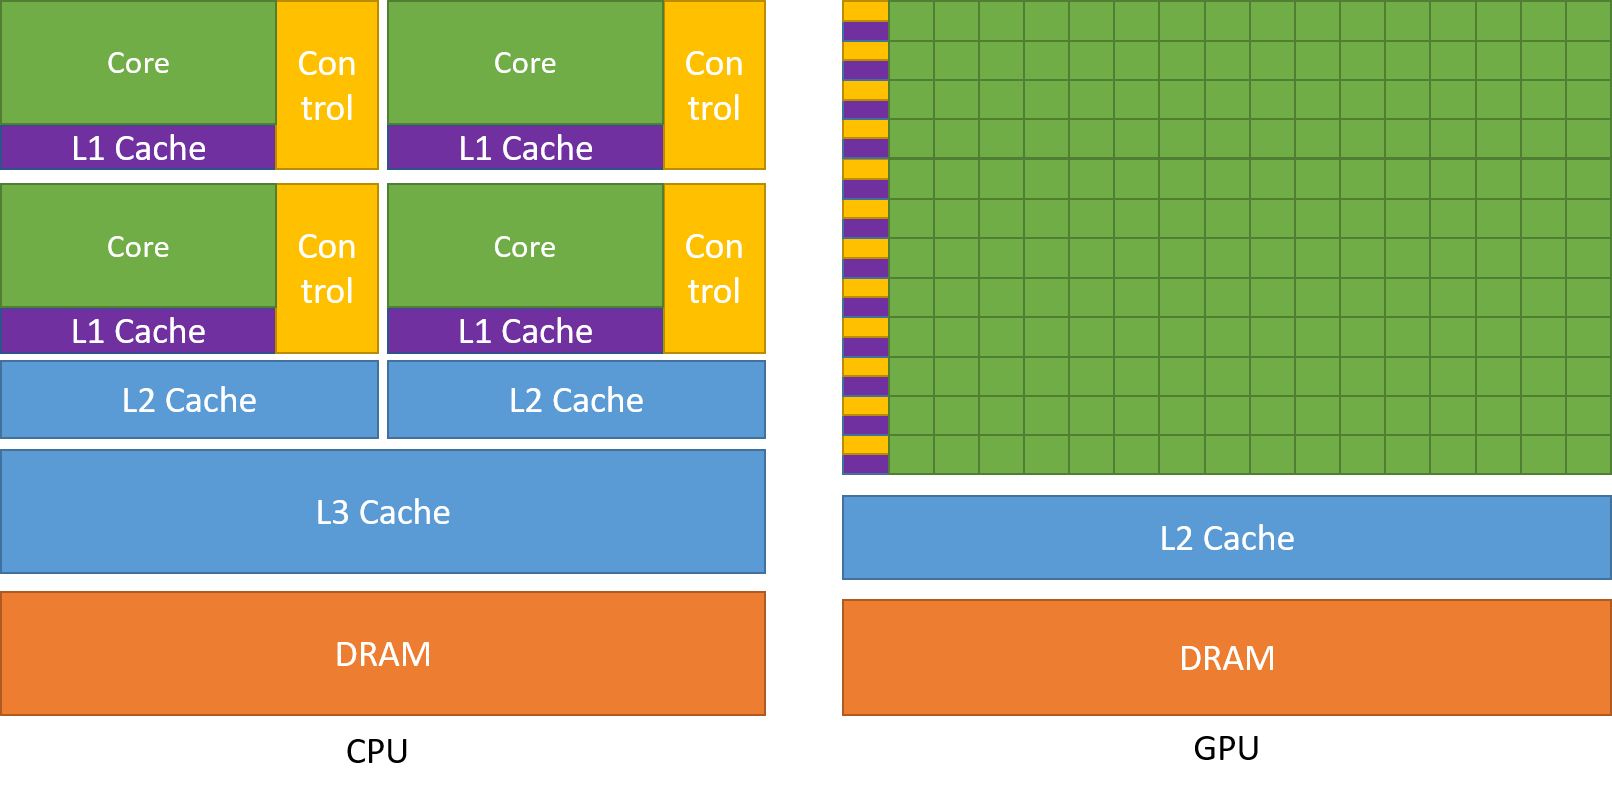
Source: https://docs.nvidia.com/cuda/cuda-c-programming-guide/

Compared to the CPU, the GPU has far more cores, but far less memory per core. Additionally, cores on the GPU are not fully independent, but typically operate in groups of 32 or 64 (called a "warp" on NVIDIA GPUs or a "wavefront" on AMD GPUs). This means that the GPU needs to be executing the same instruction on many pieces of data (called "same instruction, multiple data", or SIMD) to realize its benefits over the CPU.

Here's a table comparing some important characteristics of CPUs and GPUs:

|           | CPUs | GPUs |
|-----------|------|------|
| **General Purpose**  | Yes | No |
| **Clock Speed** | 3-4 GHz | 1-2 GHz |
| **Cache per core** | Large | Tiny |
| **Number of Cores** | A few dozen | Many thousands |
| **Programming Requirement** | No specific requirement | Requires specific programming (e.g. CUDA) |
| **Total Memory** | Hundreds of GB | Dozens of GB |
| **Memory bandwidth** | Low | High |
| **Peak theoretical performance** | Few TFLOP | Dozens of TFLOPs |
| **Performance per Watt** | Low | High |

Of all the specs above, from an HPC perspective, performance per watt may be the most important one. Most HPC facilities operate within a tight power envelope, so maximizing FLOPs (floating-point operations per second; i.e. math speed) usually means using GPUs. Power dissapation also determines the amount of cooling needed.

### That was a lot of words...
...so let's let Mythbusters [explain it](https://www.youtube.com/watch?v=-P28LKWTzrI)!


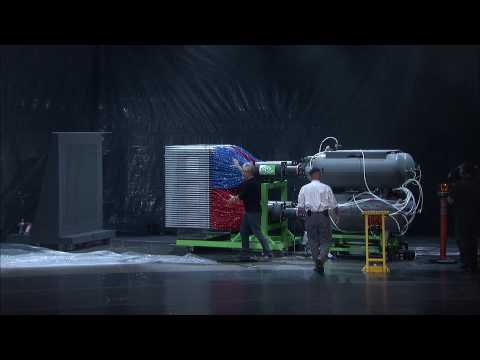

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo(id='-P28LKWTzrI',width=1000,height=600)

### How do we program the GPU?

Most GPUs used in HPC are made by NVIDIA, which also publishes the CUDA programming platform (including libraries, drivers, and a programming language). As a programming language, CUDA is an extension to C++, but today we'll look at ways to use CUDA from Python.

## Intro to CuPy

> CuPy is a NumPy/SciPy-compatible array library for GPU-accelerated computing with Python. CuPy acts as a drop-in replacement to run existing NumPy/SciPy code on NVIDIA CUDA or AMD ROCm platforms.

Source: https://docs.cupy.dev/en/stable/overview.html

In other words, CuPy is CUDA-accelerated NumPy. Let's see how this works, using some examples from the [CuPy docs](https://docs.cupy.dev/en/stable/user_guide/basic.html):

### Basics of `cupy.ndarray`

CuPy is a GPU array backend that implements a subset of NumPy interface. In the following code, `cp` is an abbreviation of `cupy`, following the standard convention of abbreviating `numpy` as `np`:

In [2]:
import numpy as np
import cupy as cp

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

We can create a `cupy.ndarray` just like we can create a `numpy.ndarray`:

In [3]:
x_cpu = np.array([1, 2, 3])
x_GPU = cp.array([1, 2, 3])

The main difference between the two is that the CuPy arrays are allocated on the GPU.

We can see this by using `cupy.ndarray.device`:

In [4]:
x_GPU.device

<CUDA Device 0>

We can use the `cupy` API to perform array operations on the GPU, like so:

In [5]:
cp.linalg.norm(x_GPU)

array(3.74165739)

or just do regular array math, and the operation will happen on the GPU:

In [6]:
x_GPU2 = x_GPU * 2
x_GPU2

array([2, 4, 6])

We can check that the result stayed on the GPU:

In [7]:
x_GPU2.device

<CUDA Device 0>

When we printed the value of `x_GPU`, it automatically fetched the result from the GPU to the CPU in order to print it. But we can also do this explicitly with `cupy.ndarray.get()`, which will return a `numpy.ndarray`:

In [8]:
x_cpu2 = x_GPU2.get()
print(x_cpu2)
print(type(x_cpu2))

[2 4 6]
<class 'numpy.ndarray'>


We can also send data back to the GPU with `cp.asarray()`:

In [9]:
cp.asarray(x_cpu).device

<CUDA Device 0>

A lot of NumPy operations will also work automatically on CuPy arrays, thanks to NumPy's ufunc and high-level function [dispatch](https://docs.cupy.dev/en/stable/user_guide/interoperability.html). So this code, despite using a NumPy call, calls the equivalent CuPy function under the hood and runs on the GPU:

In [10]:
np_res = np.linalg.norm(x_GPU)  # note np used here
print(np_res)
print(np_res.device)

3.7416573867739413
<CUDA Device 0>


## Array Operations on the GPU are Fast!

Let's start looking at performance. Since GPUs process asychronously with respect to the CPU, we'll use `stream.synchronize()` to ensure that all outstanding GPU work has completed for timing purposes.

In [11]:
stream = cp.cuda.get_current_stream()

In [12]:
%%timeit
x_GPU = cp.ones(10**8)
stream.synchronize()

1.5 ms ± 5.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
%timeit x_cpu = np.ones(10**8)

169 ms ± 52.4 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The GPU filled this array 100x faster than the CPU! We're seeing the benefit of the GPU's much larger memory bandwidth (combined with the fact that NumPy is using a single core, which usually can't saturate the CPU memory bandwidth).

We see the same results for a simple operation like multiplying the array by 2:

In [14]:
%%timeit x_GPU = cp.ones(10**8)
2 * x_GPU
stream.synchronize()

3.23 ms ± 5.26 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
x_cpu = np.ones(10**8)
%timeit 2 * x_cpu

219 ms ± 794 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## But Data Transfer is Slow
If the GPU is so fast, is it worth sending an array from the CPU to the GPU just to multiply it by 2?

In [16]:
%%timeit x_cpu = np.ones(10**8)
x_GPU = cp.asarray(x_cpu)
x_GPU *= 2
x_GPU.get()
stream.synchronize()

514 ms ± 4.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit x_cpu = np.ones(10**8)
x_cpu *= 2

65 ms ± 111 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Not even close! The CPU is many times faster than the GPU. That's because the bandwidth between the CPU and GPU (over PCI) is quite limited. In order for using the GPU to be worth it, the data needs to either:
1. originate on the GPU, and be processed there, so that only some small result is sent back to the CPU (e.g. Monte Carlo); or
2. have a high *compute density* on the GPU, meaning that a large amount of math is being done per byte of data (e.g. dense linear algebra or expensive trig)

We'll see an example of each in the problem set, but here's a quick example of (2), where it's cheaper do a matrix multiply on the GPU, even with the overhead of sending and fetching the result. We use float32 because some GPUs have limited float64 support:

In [18]:
%%timeit x_cpu = np.random.random((10000,10000)).astype(np.float32)
x_GPU = cp.asarray(x_cpu)
(x_GPU @ x_GPU).get()
stream.synchronize()

395 ms ± 4.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit x_cpu = np.random.random((10000,10000)).astype(np.float32)
x_cpu @ x_cpu

2.33 s ± 188 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Because data transfer is so slow and knowing the location of your data is so important, CuPy will never automatically copy an array from the GPU to the CPU. It will instead throw an exception, as seen in the following example:

In [20]:
np.asarray(cp.arange(10))

TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

## Numba CUDA

CuPy abstracts away the details of programming for the GPU, but CUDA has a rich computing model that's both interesting to learn about and can deliver massive speedups for complex applications. Let's get a little taste of that with Numba CUDA!

### The CUDA Progamming Model
To perform a calculation on the GPU, we write a special function called a *kernel*. The GPU executes many copies of the kernel in parallel, called a *grid*. The grid is made up of *thread blocks*, which contain many threads, all executing the kernel. The kernel can't return anything, but it can modify arrays passed as arguments.

In short, we have a two-level hierarchy of parallelism: CUDA kernels run as a grid of thread blocks. This is illustrated here:

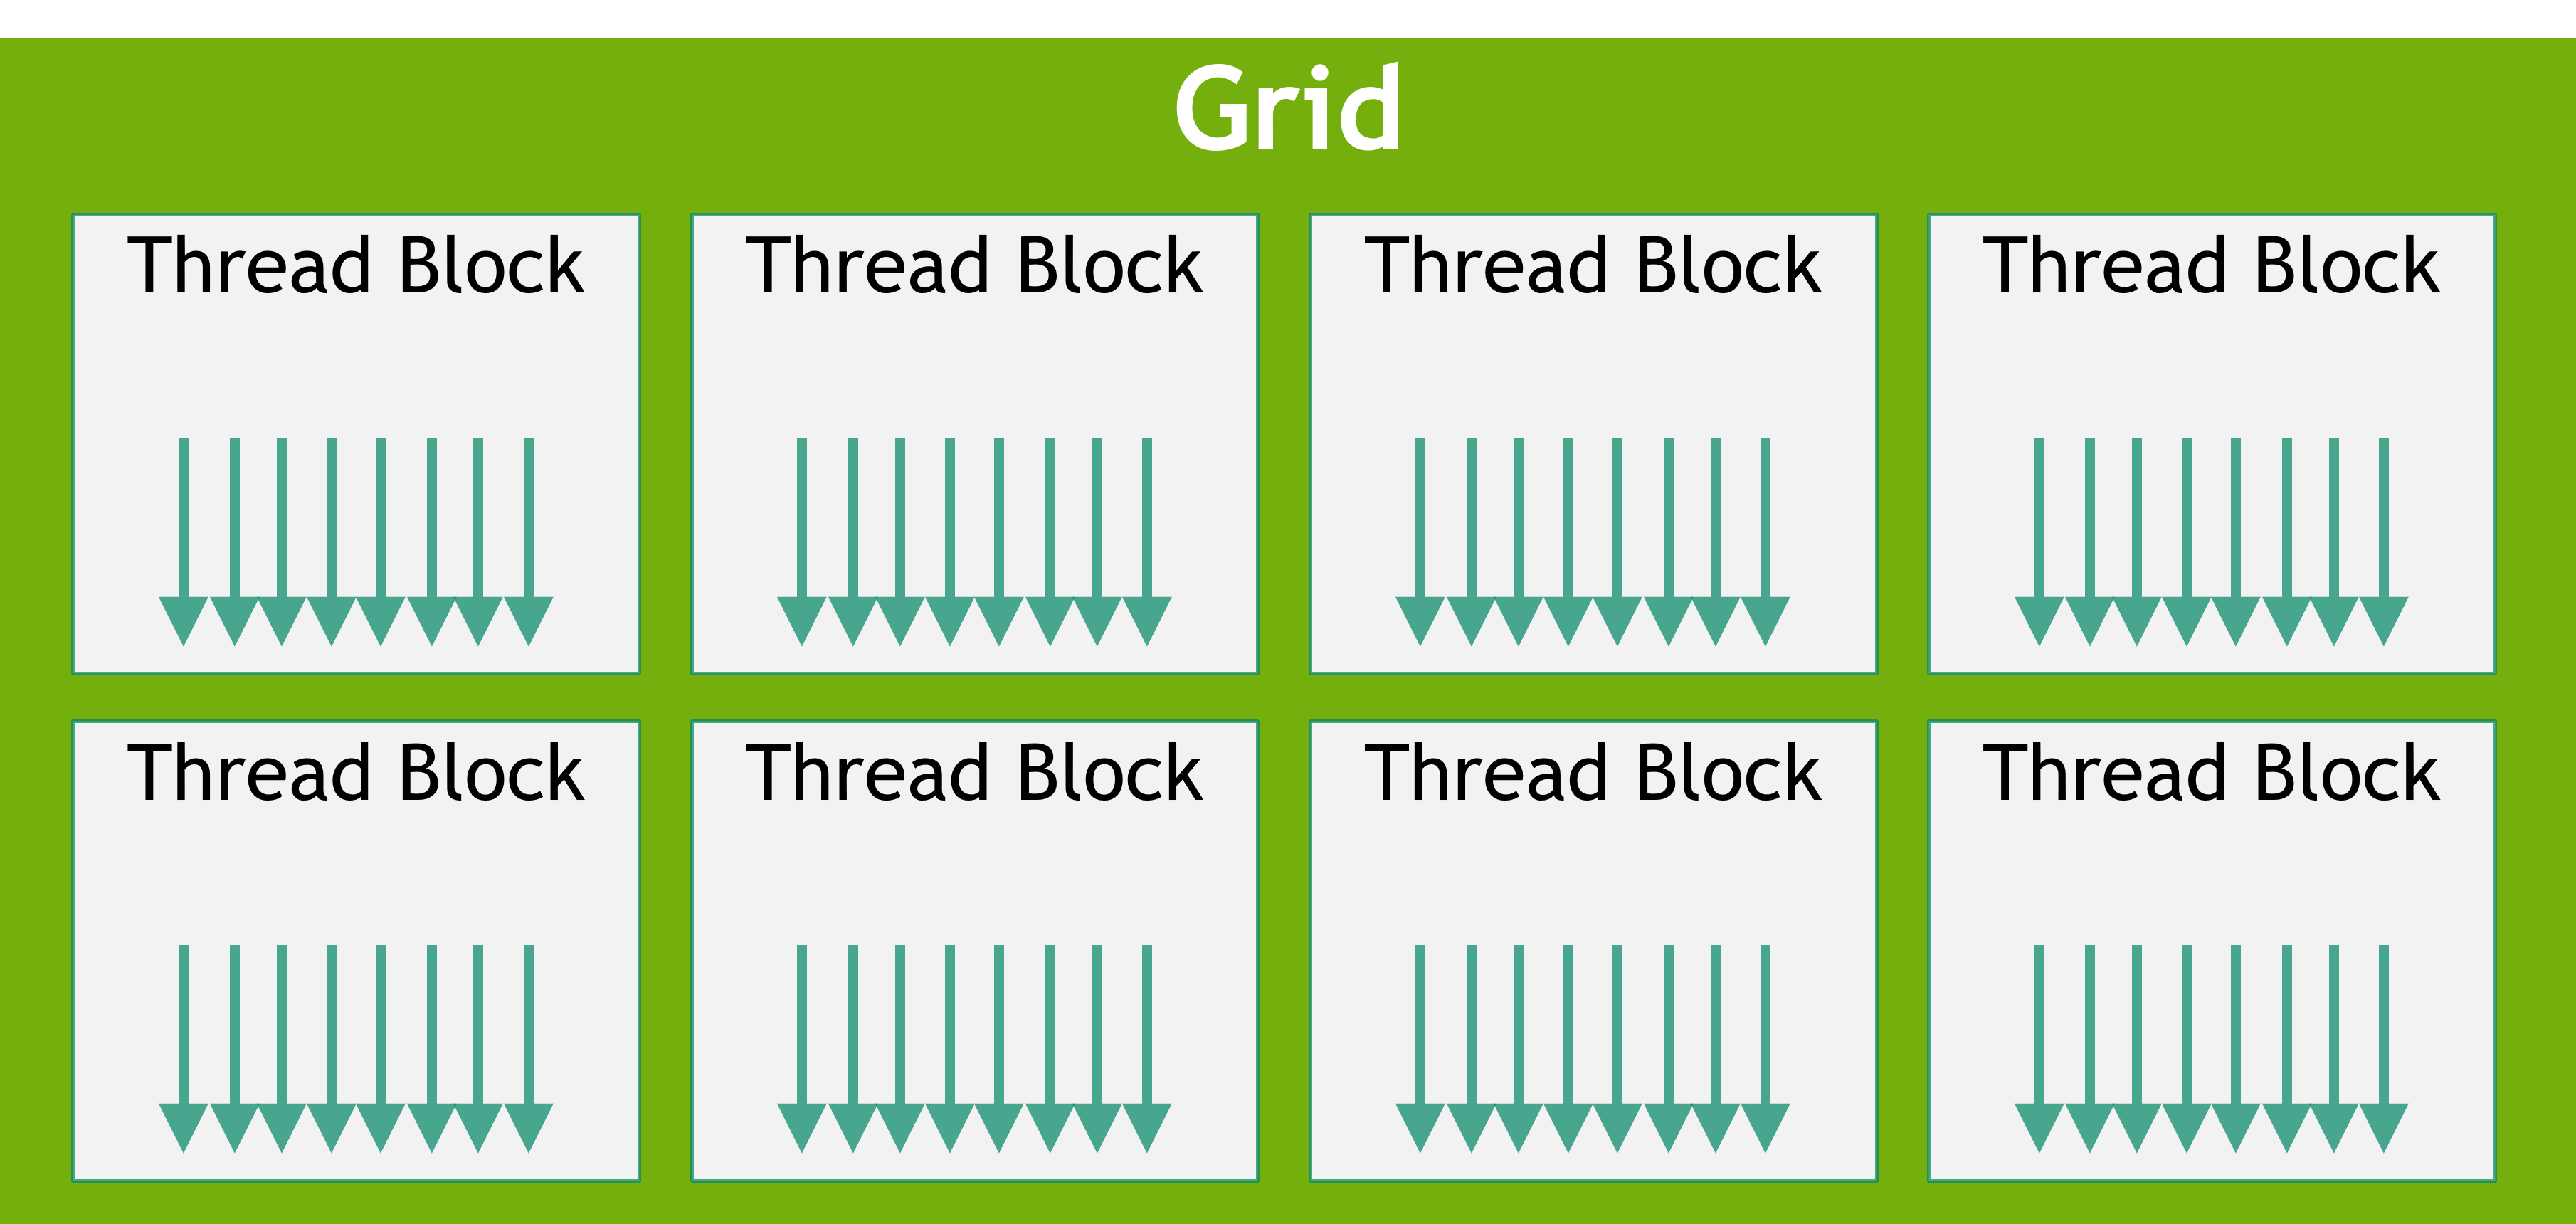
Source: https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html

### An Example Kernel
Let's try to make this a little more concrete by looking at an actual kernel:

In [21]:
from numba import cuda

@cuda.jit
def increment_by_one(arr):
    # Thread ID in a 1D block
    t = cuda.threadIdx.x
    
    # Block ID in a 1D grid
    b = cuda.blockIdx.x
    
    # Block width, i.e. number of threads per block
    w = cuda.blockDim.x
    
    # Compute flattened index inside the array
    i = t + b * w
    
    if i < arr.size:  # Check array boundaries
        arr[i] += 1

The key thing to remember is that this function effectively runs once for each thread. In other words, it runs `threads_per_block * n_blocks` times. It's as if we're writing the body of the loop, but not the loop itself.

We can imagine that CUDA is executing our function behind the scenes this way:

```python
for block_idx in range(n_blocks):
    for thread_idx in range(threads_per_block):
        increment_by_one(arr, thread_idx, block_idx)
```

Remember that CUDA does the `for`-loop parts. As the programmer, you don't write these loops, just the kernel. And in detail, all the threads in a block, and possibly all the blocks, run in parallel, but this illustrates the logical indexing.

Notice that the function is illustrated as being called with two extra arguments, `thread_idx` and `block_idx`, that don't appear in our real kernel definition above. Numba CUDA instead provides "magic" access to these variables via the `cuda.threadIdx` and `cuda.blockIdx`. It's just a bit of syntactic sugar.

The last step to execute our kernel is to decide the values of `threads_per_block` and `n_blocks`. We wrote our kernel so that each thread treats a different element of `arr`, so we need at least as many threads as `len(arr)`.  In detail, `threads_per_block` needs to be a multiple of 32, so let's just set it to 32 and choose the minimum number of blocks that covers the entire array.

In [22]:
import cupy as cp
arr = cp.ones(100)

threads_per_block = 32
n_blocks = (arr.size + (threads_per_block - 1)) // threads_per_block

increment_by_one[n_blocks, threads_per_block](arr)
cuda.synchronize()
print(arr)

/mnt/home/lgarrison/lsst-dsfp/venv/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2.]


And that's it, we've written our first CUDA kernel! Note that we used the syntax `increment_by_one[n_blocks, threads_per_block](arr)` to launch the kernel, with the block and thread dims in square brackets.

There's one shortcut that's worth mentioning, which is `cuda.grid(ndim)`. It can be called inside a kernel to do automatically the thread index calculation that we did by hand. So our kernel could look like:

In [23]:
@cuda.jit
def increment_by_one(arr):
    # global thread ID
    i = cuda.grid(1)
    
    if i < arr.size:  # Check array boundaries
        arr[i] += 1

This is a lot of new material, so don't worry if it's still confusing!  If you'd like to learn more, I would recommend Jacob Tomlinson's tutorials, since they doesn't assume any C++ knowledge: https://github.com/jacobtomlinson/gpu-python-tutorial/